# Deep Learning: Ex.12 - GAN

Submitted by: [... **Ran Ben Melech** ...]


In [25]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

print(tf.__version__)

2.2.0


***
In this exercise you will train a deep-conv GAN on the MNIST dataset.


In [26]:
# load MNIST dataset
from tensorflow.keras.datasets import mnist

#(trainX, _), (_, _) = mnist.load_data()
(trainX, trainY), _ = mnist.load_data()
dataset = trainX[...,None]
dataset = dataset.astype('float32')
dataset = dataset / 255.0  #  rescale: [0,255] to [0.0,1.0]

print('dataset.shape =',dataset.shape)

dataset.shape = (60000, 28, 28, 1)


In [27]:
# Create the generator (G_model)
latent_dim = 20

G_model = Sequential(name='G_model')
G_model.add(Dense(128*7*7, input_dim=latent_dim)) 
G_model.add(LeakyReLU(alpha=0.2))
G_model.add(Reshape((7, 7, 128)))
G_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))
G_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))
G_model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
G_model.summary()

Model: "G_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              131712    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 128)       0   

In [28]:
# Create the discriminator (D_model)

D_model = Sequential(name='D_model')
D_model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
D_model.add(LeakyReLU(alpha=0.2))
D_model.add(Dropout(0.4))
D_model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
D_model.add(Dropout(0.4))
D_model.add(Flatten())
D_model.add(Dense(1, activation='sigmoid'))
D_model.summary()

# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
D_model.compile(loss='binary_crossentropy', optimizer=opt)


Model: "D_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0   

In [29]:
# Create the combined GAN (GAN_model)

# first, make weights in the discriminator (D_model) *not* trainable
D_model.trainable = False

GAN_model = Sequential(name='GAN_model')
GAN_model.add(G_model) # add generator
GAN_model.add(D_model) # add the discriminator
GAN_model.summary()

# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
GAN_model.compile(loss='binary_crossentropy', optimizer=opt)

Model: "GAN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
G_model (Sequential)         (None, 28, 28, 1)         662529    
_________________________________________________________________
D_model (Sequential)         (None, 1)                 40705     
Total params: 703,234
Trainable params: 662,529
Non-trainable params: 40,705
_________________________________________________________________


***

### Generating a few examples from `G_model`

Use `np.random.randn()` to generate `n_examples=10` noise vectors (of dimension = `latent_dimension`).

Use these vectors as inputs to `G_model` to generate some 'fake' images (hint: `.predict()`)

Visualize the resulting 'fake' images.



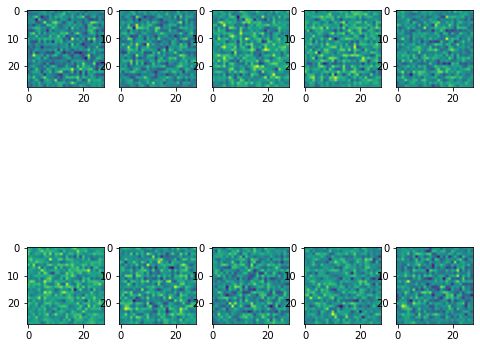

In [30]:
z=np.ndarray((10,20))

z=np.random.randn(10,20)
yhat=G_model.predict(z)
yhat =yhat[:,:,:,0]
fig=plt.figure(figsize=(8, 8))
for i in range(1,11):
    fig.add_subplot(2, 5, i)
    plt.imshow(yhat[i-1,:,:])
plt.show()

***
### Training the GAN

The basic idea of training the GAN at each step involnves:
- generating a batch of 'real' images (from the training dataset)
- generating a batch of 'fake' images (from the generator model)
- training the discriminator model on these images (real and fake)
- generating a new batch of 'fake' images, and feed them to the discriminator
- use the loss from the discriminator to train a better generator

In order to do so, as we can't just use `model.fit()`, instead, we can use `model.train_on_batch(x,y)` to train a specific model of a single batch of examples.

#### We will implement the training steps ourselves:

1. generate 'real' samples and labels (y=1) 
2. generate 'fake' examples and labels (y=0)
3. update discriminator model weights (once on the real samples and once on the fake samples)
4. generate a batch of noise (latent) vectors 
5. update the GAN model (only the generator part is `trainable`) using these inputs, as output use labels of y=1 (**explain why**)

- After each training epoch (once finished the `batch_per_epoch` loop), re-generate the examples (from previous question, using the same input seeds), to see how the generator is improving.

Training is a bit heavy, using Colab+GPU expect ~1min per epoch. 


In [31]:
n_batch = 128  # batch size
n_epochs = 50
batch_per_epoch = dataset.shape[0] // n_batch
fake_y=np.zeros((n_batch,1))
y=np.ones((n_batch, 1))
noise = np.random.randn(n_batch,20)
fake_x = G_model.predict(noise)
for i in range(n_epochs):
    for j in range(batch_per_epoch):
        
        xTrainBatch=dataset[np.random.randint(0,dataset.shape[0], size=n_batch), :, :, :]
        d_loss_real = D_model.train_on_batch(xTrainBatch, y)
        d_loss_fake = D_model.train_on_batch(fake_x, fake_y)
        noise = np.random.randn(n_batch,20)
        fake_x = G_model.predict(noise)
        g_loss = GAN_model.train_on_batch(noise, y)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


***
### Playing with the latent space

After you are satisfied with the generator results (maybe let it train for some more epochs), use it to generate 100 new examples (plot them nicely in a 10x10 subplots grid).

Next, pick 2 out of these 100 examples. We will try to "morph" between these two images, by "walking" on the latent space from `z1` (the latent vector of the 1st image) and `z2` (the latent vector of the 2nd image).

Follow the example from class, to a sequence of 15 images from the 1st image to the 2nd one.


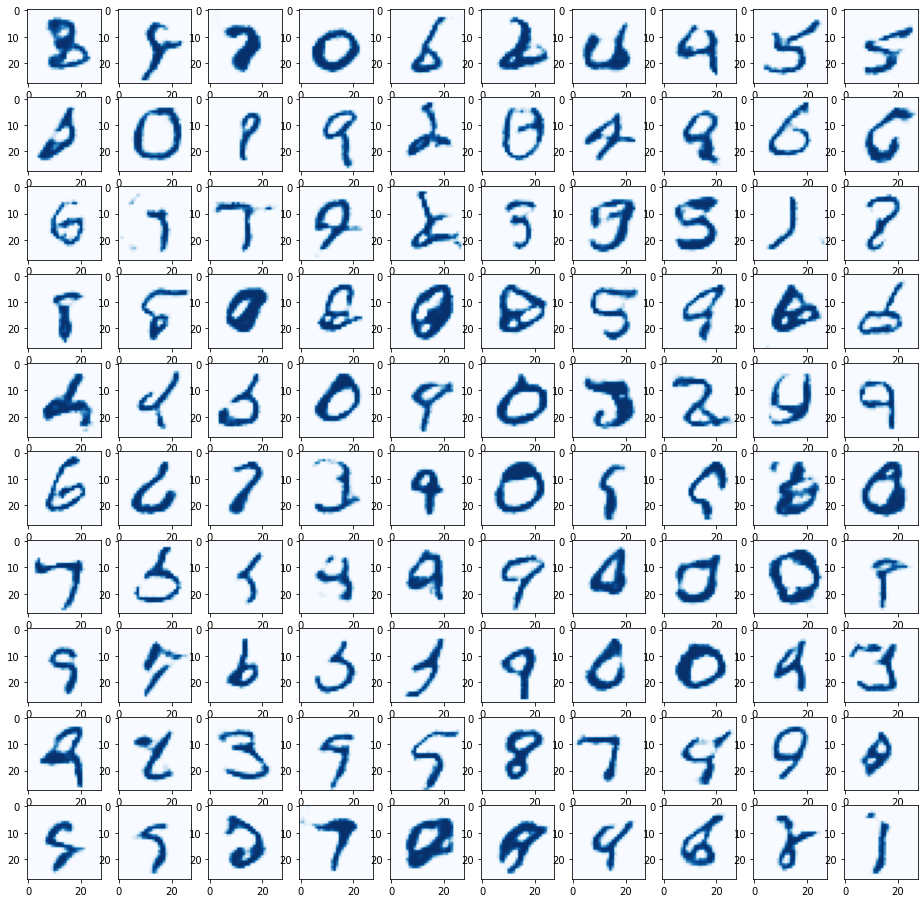

In [32]:
noise = np.random.randn(100,20)
toPlot=G_model.predict(noise)


fig, axs = plt.subplots(10, 10,figsize=(16, 16))
cnt = 0
for i in range(10):
  for j in range(10):
               axs[i,j].imshow(toPlot[cnt,:,:,0],cmap='Blues')
               cnt += 1


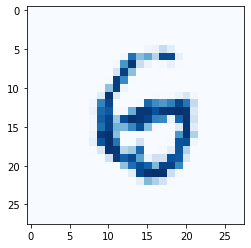

In [36]:
plt.imshow(toPlot[20,:,:,0],cmap='Blues')

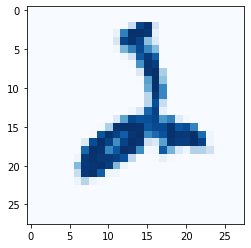

In [37]:
plt.imshow(toPlot[14,:,:,0],cmap='Blues')

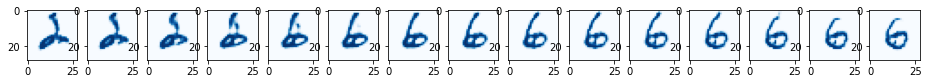

In [43]:
toMorph=np.ndarray(shape=(15,20))
a=0
for i in range(15):
  toMorph[i]=(a*noise[20])+((1-a)*noise[14])
  a+=0.06
res=G_model.predict(toMorph)

fig, axs = plt.subplots(1, 15,figsize=(16, 16))
cnt = 0

for j in range(15):
      axs[j].imshow(res[cnt,:,:,0],cmap='Blues')
      cnt += 1

***
## Good Luck!